In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.tri import Triangulation
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.optimize import curve_fit
import time

# 1) Géometrie

_question a)_

In [78]:
def GenerateRectangleMesh(Lx, Ly, Nx, Ny):
    pas_h = Lx / Nx
    pas_v = Ly / Ny
    nb_vertices = (Nx + 1) * (Ny + 1) # Nombre total de sommets
    nb_elements = Nx * Ny * 2 # Nombre d'éléments = triangles 
    vtx = []  # Matrice de coordonnées
    elt = []  # Matrice de connectivité
    
    # Génère les coordonnées des nœuds
    x = np.linspace(0,Lx,Nx+1)
    y = np.linspace(0,Ly,Ny+1)
    
    X,Y = np.meshgrid(x,y) # Genère un quadrillage 
    
    for i in range(0,Ny+1):
        for j in range(0,Nx+1):
            vtx.append([X[i,j],Y[i,j]])
    
    # Genère les éléments triangulaires
    for i in range(Ny):
        for j in range(Nx):
            # Premier triangle
            elt.append([i * (Nx + 1) + j, i * (Nx + 1) + j + 1, (i + 1) * (Nx + 1) + j + 1])
            # Deuxième triangle
            elt.append([i * (Nx + 1) + j, (i + 1) * (Nx + 1) + j + 1, (i + 1) * (Nx + 1) + j])
        
    
    return np.array(vtx), np.array(elt)

# Exemple de l'énoncé :
Lx = 1
Ly = 1
Nx = 2
Ny = 2
vtx, elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
print("Matrice de coordonnées des nœuds vtx :")
print(vtx)
print("Matrice de connectivité des éléments elt:")
print(elt)

Matrice de coordonnées des nœuds vtx :
[[0.  0. ]
 [0.5 0. ]
 [1.  0. ]
 [0.  0.5]
 [0.5 0.5]
 [1.  0.5]
 [0.  1. ]
 [0.5 1. ]
 [1.  1. ]]
Matrice de connectivité des éléments elt:
[[0 1 4]
 [0 4 3]
 [1 2 5]
 [1 5 4]
 [3 4 7]
 [3 7 6]
 [4 5 8]
 [4 8 7]]


_question b)_

La méthode générale est expliquée dans le rapport lié au projet

Déterminons tout d'abord une fonction permettant de retourner seulement les triangles possédant des arêtes adjacentes aux sommets 0 : 

In [5]:
def Triangle0(elt):
    triangle_0 = []
    for triangle in elt:
        if 0 in triangle:
            triangle_0.append(triangle)
    return np.array(triangle_0)

In [6]:
# test de la fonction
print(Triangle0(elt))

[[0 1 4]
 [0 4 3]]


Définissons maintenant les nouveaux sommets : 

In [7]:
def new_vert(vtx,elt):
    
    # Nouveau sommet en absisse
    v1 = vtx[Triangle0(elt)[0][0]][0]
    
    v2 = vtx[Triangle0(elt)[0][1]][0]
    
    v3 = vtx[Triangle0(elt)[0][0]][1]
    
    v4 = vtx[Triangle0(elt)[0][1]][1] 
    
    snew1 = ((v1+v2)/2,(v3 + v4)/2)
    
    # Nouveau sommet en ordonnée
    c1 = vtx[Triangle0(elt)[1][0]][0]
    
    c2 = vtx[Triangle0(elt)[1][2]][0]
    
    c3 = vtx[Triangle0(elt)[1][0]][1]
    
    c4 = vtx[Triangle0(elt)[1][2]][1]
    
    snew2 = ((c1+c2)/2,(c3 + c4)/2)
    
    # Nouveau sommet en diagonal
    s1 = vtx[Triangle0(elt)[1][2]][0]
    
    s2 = vtx[Triangle0(elt)[1][2]][1]
    
    snew3 = ((v2 + s1)/2,(v4 + s2)/2)
    
    new_row = np.array([snew1,snew2,snew3])
    
    vtx_new = np.vstack([vtx,new_row]) # Permet de rajouter une ligne au tableau vtx
    
    return vtx_new

In [8]:
new_vert(vtx,elt)

array([[0.  , 0.  ],
       [0.5 , 0.  ],
       [1.  , 0.  ],
       [0.  , 0.5 ],
       [0.5 , 0.5 ],
       [1.  , 0.5 ],
       [0.  , 1.  ],
       [0.5 , 1.  ],
       [1.  , 1.  ],
       [0.25, 0.  ],
       [0.  , 0.25],
       [0.25, 0.25]])

In [9]:
def GeometricRefinement(vtx, elt,r):
    
    new_vtx = vtx
    
    new_elt = elt
    
    for i in range(0,r):
        new_vtx = new_vert(new_vtx, new_elt)
        
        j = len(new_vtx)-1 # on commence à 0 d'ou le -1

        t6 = np.array([j,new_elt[0][1],new_elt[0][2]])

        t5 = np.array([j,new_elt[1][1],new_elt[1][2]])

        t4 = np.array([j,j-2,new_elt[0][1]])

        t3 = np.array([j,new_elt[1][2],j-1])

        t2 = np.array([0,j,j-1])

        t1 = np.array([0,j-2,j])
        
        new_elt = np.delete(new_elt, [0,1], axis=0) # Supprimer les triangles originaux que l'on vient de subdiviser

        new_elt = np.vstack([np.array([t1,t2,t3,t4,t5,t6]),new_elt])

    return new_vtx, new_elt


In [10]:
# Test de la fonction
print(GeometricRefinement(vtx,elt,1)[1])

[[ 0  9 11]
 [ 0 11 10]
 [11  3 10]
 [11  9  1]
 [11  4  3]
 [11  1  4]
 [ 1  2  5]
 [ 1  5  4]
 [ 3  4  7]
 [ 3  7  6]
 [ 4  5  8]
 [ 4  8  7]]


_question c)_

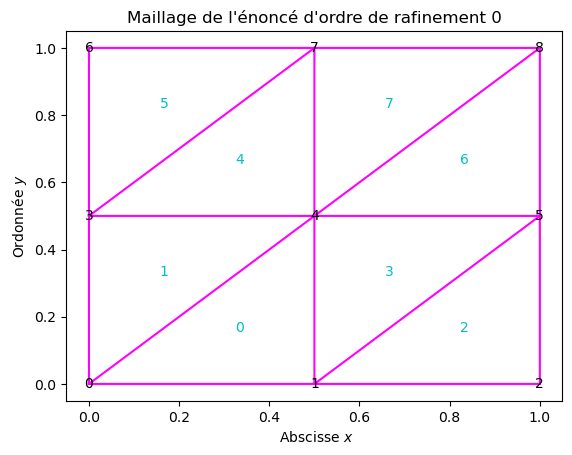

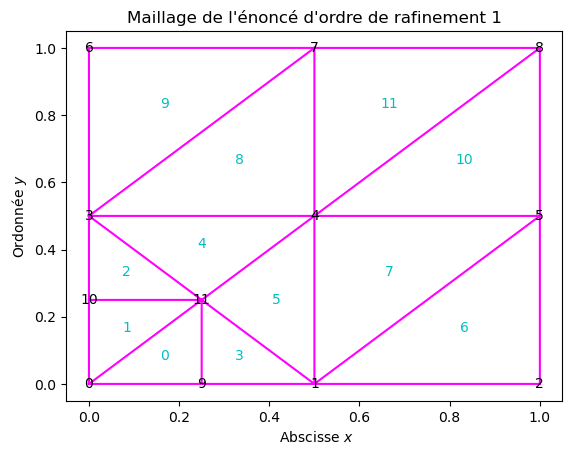

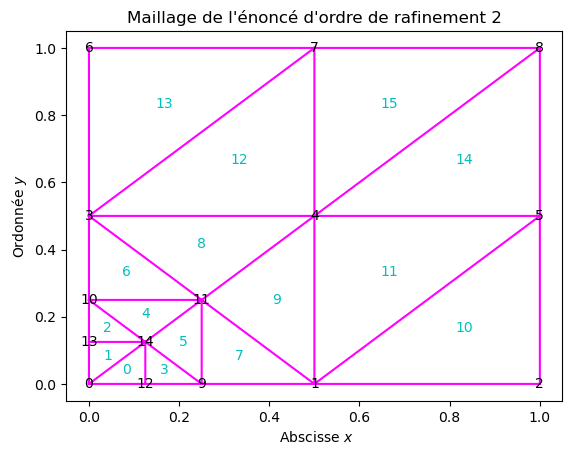

In [11]:
def PlotMesh(raffinement):
    vtx, elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    vtx, elt = GeometricRefinement(vtx,elt,raffinement) 
    x = vtx[:,0]
    y = vtx[:,1]
    triang = mtri.Triangulation(x, y, elt) # Créer un objet de triangulation pour le plot
    plt.triplot(triang,color='magenta')
    
    # Numérotation des triangles 
    for i, triangle in enumerate(elt):
        centroid_x = np.mean(x[triangle])
        centroid_y = np.mean(y[triangle])
        plt.text(centroid_x, centroid_y, str(i), horizontalalignment='center', verticalalignment='center',color='c')
        
    # Numérotation des sommets
    for i, point in enumerate(vtx):
        plt.text(point[0], point[1], str(i), horizontalalignment='center', verticalalignment='center', color='black')
        
    plt.xlabel(r' Abscisse $x$')
    plt.ylabel(r'Ordonnée $y$')
    plt.title(f"Maillage de l'énoncé d'ordre de rafinement {raffinement}")
    plt.savefig(f"raffinement_{raffinement}.png")
    plt.show()

# test sur le maillage de l'énoncé, Nx = Ny = 2, Lx = Ly = 1
PlotMesh(0)
PlotMesh(1)
PlotMesh(2)

# 2) Problème 

_question b)_

Bord du maillage : 

In [12]:
def Boundary(elt):
    bord = set() 
    for e in elt:
        a0 = tuple(sorted([e[1], e[2]]))
        a1 = tuple(sorted([e[0], e[2]]))
        a2 = tuple(sorted([e[0], e[1]]))
        aretes = [a0, a1, a2]
         
        for a in aretes:
            if a in bord:
                bord.remove(a)
            else:
                bord.add(a)
    bord_list = [list(a) for a in bord]
    return set(np.reshape(bord_list,(1,2*len(bord_list)))[0])

In [13]:
# test de la fonction
Boundary(elt)

{0, 1, 2, 3, 5, 6, 7, 8}

Matrice de masse locale : 

In [14]:
def Mloc(vtx, elt):
    
    T = np.linalg.norm(np.cross(vtx[elt[0]] - vtx[elt[1]] , vtx[elt[1]] - vtx[elt[2]]))/2
    
    return T * np.array([[2,1,1],[1,2,1],[1,1,2]]) / 12 # Formule du cours

In [15]:
# test de la fonction
Mloc(vtx,elt)

array([[0.02083333, 0.01041667, 0.01041667],
       [0.01041667, 0.02083333, 0.01041667],
       [0.01041667, 0.01041667, 0.02083333]])

Matrice de masse globale

In [79]:
def Mass(vtx,elt):
    
    d = len(elt[0]) 
    Nc = len(elt)
    Nv = len(vtx)

    I = np.zeros(((d+1)**2)*Nc,dtype = int)
    J = np.zeros(((d+1)**2)*Nc,dtype = int)
    V = np.zeros(((d+1)**2)*Nc,dtype = float)
    
    for l in range(Nc): # Boucle sur les triangles
        matloc = Mloc(vtx,elt[l]) # matrice locale
        for j in range(d): 
            for k in range(d):
                i = ((d+1)**2)*(l-1)+(d+1)*j + k 
                I[i] = elt[l][j] # On associe dans M globale les contributions de la matrice locale 
                J[i] = elt[l][k] 
                V[i] = matloc[j,k] # Mglobale(I,J) = Mloc(j,k)
                
    M = csr_matrix((V, (I, J)), shape = (Nv,Nv)).toarray()
    return M

In [80]:
# test de la fonction 
print(Mass(vtx,elt))

[[0.04166667 0.01041667 0.         0.01041667 0.02083333 0.
  0.         0.         0.        ]
 [0.01041667 0.0625     0.01041667 0.         0.02083333 0.02083333
  0.         0.         0.        ]
 [0.         0.01041667 0.02083333 0.         0.         0.01041667
  0.         0.         0.        ]
 [0.01041667 0.         0.         0.0625     0.02083333 0.
  0.01041667 0.02083333 0.        ]
 [0.02083333 0.02083333 0.         0.02083333 0.125      0.02083333
  0.         0.02083333 0.02083333]
 [0.         0.02083333 0.01041667 0.         0.02083333 0.0625
  0.         0.         0.01041667]
 [0.         0.         0.         0.01041667 0.         0.
  0.02083333 0.01041667 0.        ]
 [0.         0.         0.         0.02083333 0.02083333 0.
  0.01041667 0.0625     0.01041667]
 [0.         0.         0.         0.         0.02083333 0.01041667
  0.         0.01041667 0.04166667]]


In [18]:
Lx = 1
Ly = 1
Nx = 2
Ny = 2
# Test de la matrice de masse comme vu en cours
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
M = Mass(vtx,elt)
V = np.ones(len(vtx))
aire = np.transpose(V)@(M@V)
print(aire)

1.0


Ceci est bien égal à l'aire du maillage

Matrice de rigidité locale :

In [19]:
def mu(v,Lx,Ly):
    
    x = v[0]
    y = v[1]
    
    return 2+np.sin(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly)

In [20]:
def Kloc(vtx,elt,Lx,Ly):
    
    d = len(elt) 
    normal = np.zeros((d,2))
    K0 = np.zeros((d,d))
    K = np.zeros((d,d))
    # On applique les formules du cours pour déterminer les vecteurs normaux nj et nk
    
    for i in range(3):
        
        cross = np.cross([0,0,1],vtx[elt[(i+1)%3]]-vtx[elt[(i+2)%3]])
        
        # Ici le vecteur normal est de taille 3, on ne récupère seulement que les deux premières composantes car produit vectoriel dans R^2
        normal[i] = cross[:2]
        
    for j in range(3):
        
        for k in range(3):
            
            num = np.dot(normal[j],normal[k])
            denum = (np.dot((vtx[elt[j%3]]-vtx[elt[(j+1)%3]]),normal[j%3]))*(np.dot((vtx[elt[k%3]]-vtx[elt[(k+1)%3]]),normal[k%3]))
            K0[j][k] = num/denum


    aire = np.linalg.norm(np.cross(vtx[elt[0]]-vtx[elt[1]],vtx[elt[1]]-vtx[elt[2]]))/2
    
    v = 0
    
    for i in range(3):
        
        v += mu(vtx[elt[i]],Lx,Ly) # On interpole la fonction mu sur chacun des noeuds du maillage

    K = K0 * (1/3)* v * aire
    return K

In [21]:
# test de la fonction 
Kloc(vtx,elt[0],1,1)

array([[ 1., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  1.]])

Matrice de rigidité globale

In [22]:
def Rig(vtx,elt,Lx,Ly):
    
    d = len(elt[0]) 
    Nc = len(elt)
    Nv = len(vtx)

    I = np.zeros(((d+1)**2)*Nc,dtype = int)
    J = np.zeros(((d+1)**2)*Nc,dtype = int)
    V = np.zeros(((d+1)**2)*Nc,dtype = float)
    
    for l in range(Nc): # Boucle sur les triangles
        rigloc = Kloc(vtx,elt[l],Lx,Ly) 
        for j in range(d): # On associe dans M globale les contributions de la matrice locale 
            for k in range(d):
                i = ((d+1)**2)*(l-1)+(d+1)*j + k 
                I[i] = elt[l][j]
                J[i] = elt[l][k] 
                V[i] = rigloc[j,k] # Mglobale(I,J) = Mloc(j,k)
    R = csr_matrix((V, (I, J)), shape = (Nv,Nv)).toarray()
    return R

In [23]:
# test de la fonction 
print(Rig(vtx,elt,1,1))

[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -2.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -2.  0. -1.  0.  0.]
 [ 0. -2.  0. -2.  8. -2.  0. -2.  0.]
 [ 0.  0. -1.  0. -2.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -2.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  2.]]


In [24]:
Lx = 1
Ly = 1
Nx = 2
Ny = 2
# Test de la matrice de rigidité comme vu en cours
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
R = Rig(vtx,elt,Lx,Ly)
V = np.ones(len(vtx))
aire = np.transpose(V)@(R@V)
print(aire)

0.0


_question c)_

Matrice d'assemblage avec méthode de pseudo élimination pour prendre en compte les conditions aux limites 

In [25]:
def Diagonale(vtx,bord): # Renvoie 1 sur la diagonale si le noeud est sur le bord, sinon 0
    D = np.zeros((len(vtx),len(vtx)))
    
    for i in range(len(vtx)):
        for j in range(len(vtx[i])):
            noeud = vtx[i,j]
            if noeud in bord:
                D[i,i] = 1
    return csr_matrix(D).toarray()

In [26]:
# Test de la fonction
Lx = 1
Nx = 2
Ny = 2
Ly = 1
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
print(Diagonale(vtx,Boundary(elt))) # Noeud numéro 4 n'appartenant pas au bord

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [27]:
def MatA(vtx,elt,bord):
    M = Mass(vtx,elt)
    K = Rig(vtx,elt,Lx,Ly)
    D = Diagonale(vtx,bord)
    I = np.eye(len(vtx))
    A = M+K
    return csr_matrix((I-D)@A + D).toarray() # pseudo elimination car conditions aux limites de Dirichlet

# 3) Second membre

_question a)_

In [28]:
def uex(v,Lx,Ly,alpha):
    x = v[0]
    y = v[1]
    return ((x*y)**alpha)*(x-Lx)*(y-Ly)

In [29]:
def dx_uex(v,Lx,Ly,alpha):
    
    x = v[0]
    y = v[1]
    
    if (alpha==1): #ici et dans le reste, on veut éviter les divisions par 0
        dx = (y-Ly)*(2*y*x - y*Lx)
        
    else : 
        if (x == 0 or y == 0):
            dx = 0
        else:
            dx = ((y**alpha)*(y-Ly))*(alpha*(x**(alpha-1))*(x-Lx)+ x**alpha)
    return dx

In [30]:
def dy_uex(v,Lx,Ly,alpha):
    
    x = v[0]
    y = v[1]
    
    if (alpha==1):
        dy = (x-Lx)*(2*x*y - x*Ly)
        
    else : 
        if (y==0 or x == 0):
            dy = 0
        else:
            dy = ((x**alpha)*(x-Lx))*(alpha*(y**(alpha-1))*(y-Ly)+ y**alpha)
        
    return dy

In [31]:
def dx2_uex(v,Lx,Ly,alpha):
    
    x = v[0]
    y = v[1]
    
    if (alpha==1) :
        dx2 = (y-Ly)*2*y
    else : 
        if (x==0 or y==0):
            dx2 = 0
        else: 
            
            dx2 = ((y**alpha)*(y-Ly))*(alpha*(alpha-1)*x**(alpha-2)*(x-Lx)+2*alpha*x**(alpha-1))
    
    return dx2

In [32]:
def dy2_uex(v,Lx,Ly,alpha):
    
    x = v[0]
    y = v[1]
    
    if (alpha==1) :
        dy2 = (x-Lx)*2*x
    else : 
        if (y==0 or x == 0):
            dy2 = 0
        else:
            dy2 = ((x**alpha)*(x-Lx))*(alpha*(alpha-1)*y**(alpha-2)*(y-Ly)+2*alpha*y**(alpha-1))
    
    return dy2

In [33]:
def mu(v,Lx,Ly):
    
    x = v[0]
    y = v[1]
    
    return 2+np.sin(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly)

In [34]:
def dx_mu(v,Lx,Ly):
    
    x = v[0]
    y = v[1]
    
    return (2*np.pi/Lx)*np.cos(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly)

In [35]:
def dy_mu(v,Lx,Ly):
    
    x = v[0]
    y = v[1]
    
    return (4*np.pi/Ly)*np.sin(2*np.pi*x/Lx)*np.cos(4*np.pi*y/Ly)

_question b)_

In [36]:
def second_membre_exacte_f(v,Lx,Ly,alpha):
    
    laplacien = dx2_uex(v,Lx,Ly,alpha) + dy2_uex(v,Lx,Ly,alpha)
    
    grad_mu = np.array([dx_mu(v,Lx,Ly),dy_mu(v,Lx,Ly)])
    
    grad_uex = np.array([dx_uex(v,Lx,Ly,alpha),dy_uex(v,Lx,Ly,alpha)])
    
    return - mu(v,Lx,Ly)*laplacien - np.dot(np.transpose(grad_mu),grad_uex) + uex(v,Lx,Ly,alpha) 

_question c)_

In [37]:
def second_membre_approx_f(vtx, elt, Lx, Ly, alpha):
    F = np.zeros(len(vtx))
    for t in range(len(elt)):
        triangle = elt[t]
        s0 = vtx[triangle[0]]
        s1 = vtx[triangle[1]]
        s2 = vtx[triangle[2]]
        point = (s0 + s1 + s2) / 3
        aire = np.linalg.norm(np.cross(s1 - s0, s2 - s0)) / 2
        indices = np.where(np.isin(triangle, np.arange(len(vtx))))[0] 
        #  Détermine quels indices des sommets du triangle t sont dans la liste des sommets du maillage
        F[triangle[indices]] += second_membre_exacte_f(point, Lx, Ly, alpha) * (1 / 3) * aire
    return F

In [38]:
vtx,elt = GenerateRectangleMesh(1,1,2,2)
vtx,elt = GeometricRefinement(vtx,elt,0)
print(second_membre_approx_f(vtx,elt,1,1,1))

[0.18907049 0.23763244 0.01924242 0.18094737 0.56916547 0.18094737
 0.01924242 0.23763244 0.18907049]


# 4) Résolution 

_question a)_

In [39]:
def systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord):
    
    
    A_ = MatA(vtx,elt,bord)

    f = second_membre_approx_f(vtx,elt,Lx,Ly,alpha)
 
    I = np.eye(len(vtx))
    

    D = Diagonale(vtx,bord)
    

    b = (I-D)@f # pseudo élimination
    
 
    solution = np.linalg.solve(A_, b)
    
    
    return solution

_question b)_

In [40]:
def PlotApproximation(vtx,elt,fct,stri):
    
    x = [v[0] for v in vtx] 
    y = [v[1] for v in vtx]
    triangulation = mtri.Triangulation(x,y,elt)

    fig, ax = plt.subplots()
    figure = ax.tripcolor(triangulation,fct)
    fig.colorbar(figure)
    plt.plot(x, y, 'o', color='black',markersize=1)
    plt.xlabel('Abscisse x')
    plt.ylabel('Ordonnée y')
    plt.title(f'Graphique de {stri}')
    plt.axis('equal')
    plt.show()
    
def interpolation_u_ex(vtx,alpha,Lx,Ly):
    
    PIU = np.zeros(len(vtx))
    for i in range(len(vtx)): 
        PIU[i] = uex((vtx[i][0],vtx[i][1]),Lx,Ly,alpha)
    return PIU

def erreur(Lx,Ly,Nx,Ny,alpha): 
    Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
    Interpolation_uex = interpolation_u_ex(vtx,alpha,Lx,Ly)
    return np.abs(Uh - Interpolation_uex)


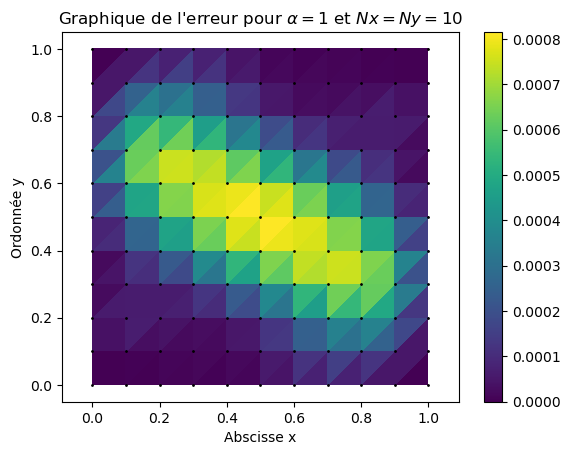

In [41]:
Lx = 1
Ly = 1
alpha = 1
N = 10
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
bord = Boundary(elt)
e = erreur(Lx,Ly,Nx,Ny,alpha)
PlotApproximation(vtx,elt,e,r"l'erreur pour $\alpha = 1$ et $Nx = Ny = 10$")

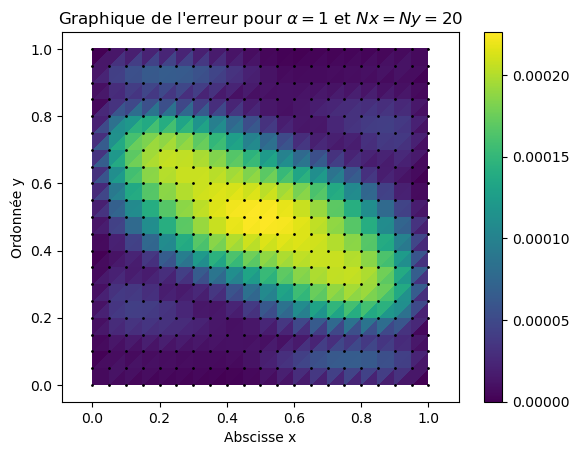

In [42]:
Lx = 1
Ly = 1
alpha = 1
N = 20
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
e = erreur(Lx,Ly,Nx,Ny,alpha)
PlotApproximation(vtx,elt,e,r"l'erreur pour $\alpha = 1$ et $Nx = Ny = 20$")

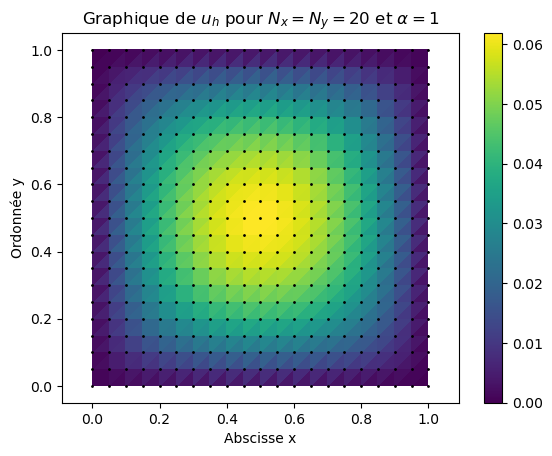

In [43]:
Lx = 1
Ly = 1
alpha = 1
N = 20
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
bord = Boundary(elt)
e = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
PlotApproximation(vtx,elt,e,r"$u_h$ pour $N_x = N_y = 20$ et $\alpha = 1$")

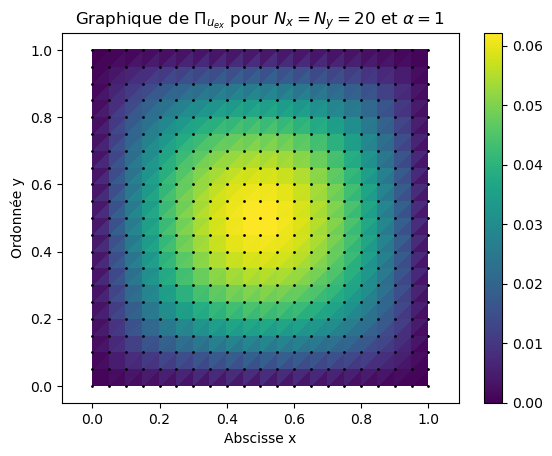

In [44]:
Lx = 1
Ly = 1
alpha = 1
N = 20
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
e = interpolation_u_ex(vtx,alpha,Lx,Ly)
PlotApproximation(vtx,elt,e,r"$\Pi_{u_{ex}}$ pour $N_x = N_y = 20 $ et $\alpha = 1$")

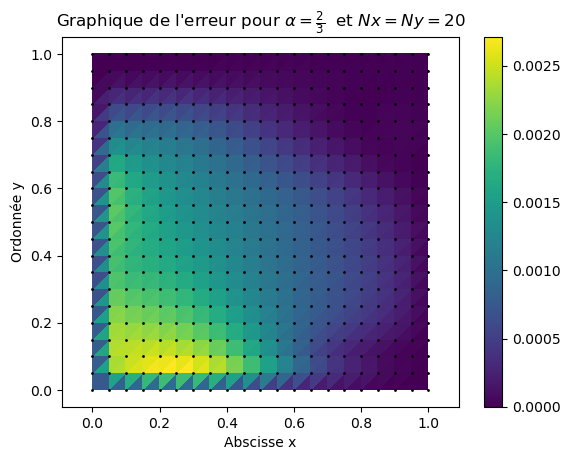

In [45]:
Lx = 1
Ly = 1
alpha = 2/3
N = 20
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
e = erreur(Lx,Ly,Nx,Ny,alpha)
PlotApproximation(vtx,elt,e,r"l'erreur pour $\alpha = \frac{2}{3}$  et $Nx = Ny = 20$")

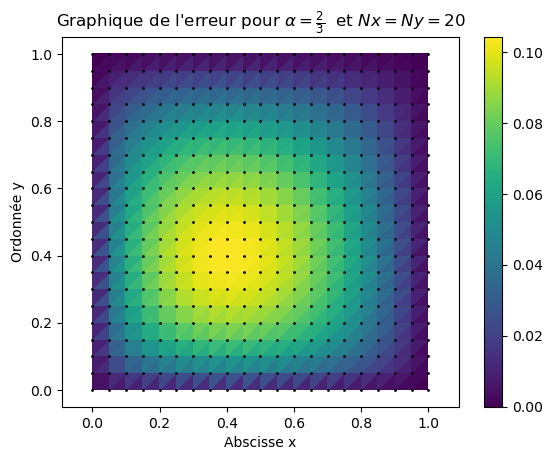

In [46]:
Lx = 1
Ly = 1
alpha = 2/3
N = 20
Nx = N
Ny = N
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
bord = Boundary(elt)
e = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
PlotApproximation(vtx,elt,e,r"l'erreur pour $\alpha = \frac{2}{3}$  et $Nx = Ny = 20$")

_question c)_

Erreur norme L2

In [62]:
def L2(err,Inter,M):
    num = err@M@err
    denum = Inter@M@Inter
    return np.sqrt(num/denum)

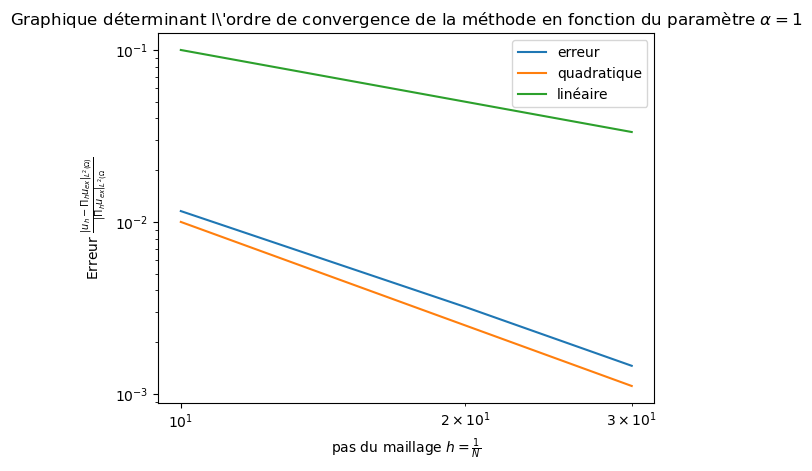

Temps d'exécution: 2.4368677139282227 secondes


In [74]:

start_time = time.time()


L1 = []
NL = []
NLQ = []
NLL = []
for N in [10,20,30]:
    Nx = N
    Ny = N
    Lx = 1
    Ly = 1
    alpha = 1
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    vtx,elt = GeometricRefinement(vtx,elt,0)
    bord = Boundary(elt)
    Ma = Mass(vtx,elt)
    K = Rig(vtx,elt,Lx,Ly)
    Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
    Interp = interpolation_u_ex(vtx,alpha,Lx,Ly)
    erro = Uh - Interp
    val = L2(erro,Interp,Ma)
    L1.append(val)
    NL.append(N)
    NLQ.append(1/N**2)
    NLL.append(1/N)
    
end_time = time.time()

execution_time = end_time - start_time

plt.loglog(NL,L1, label = "erreur")
plt.plot(NL,NLQ, label = "quadratique")
plt.plot(NL,NLL,label= "linéaire")
plt.title(r'Graphique déterminant l\'ordre de convergence de la méthode en fonction du paramètre $\alpha = 1$')
plt.xlabel(r'pas du maillage $h = \frac{1}{N}$') # N = Nx = Ny ici
plt.ylabel(r'Erreur $\frac{\|u_h - \Pi_h u_{ex}\|_{L^2(\Omega)}}{\|\Pi_h u_{ex}\|_{L^2(\Omega}}$')
plt.legend()
plt.show()
print("Temps d'exécution:", execution_time, "secondes")

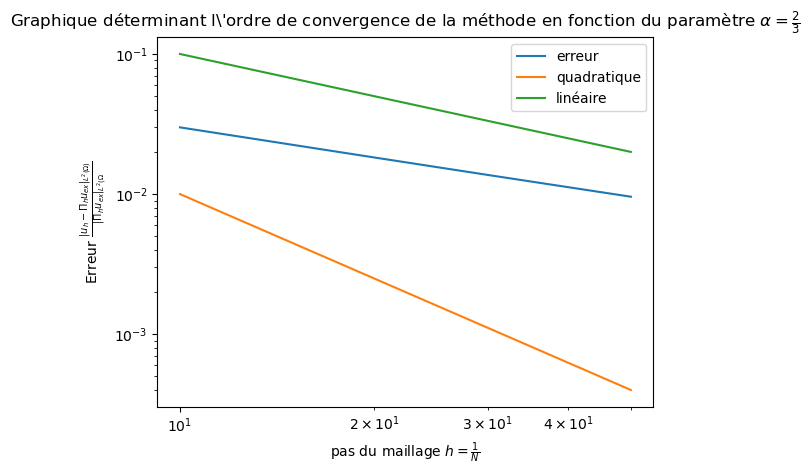

Temps d'exécution: 6.821723699569702 secondes


In [76]:
start_time = time.time()


L1 = []
NL = []
NLQ = []
NLL = []
for N in [10,20,30,50]:
    Nx = N
    Ny = N
    Lx = 1
    Ly = 1
    alpha = 2/3
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    vtx,elt = GeometricRefinement(vtx,elt,0)
    bord = Boundary(elt)
    Ma = Mass(vtx,elt)
    K = Rig(vtx,elt,Lx,Ly)
    Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
    Interp = interpolation_u_ex(vtx,alpha,Lx,Ly)
    erro = Uh - Interp
    val = L2(erro,Interp,Ma)
    L1.append(val)
    NL.append(N)
    NLQ.append(1/N**2)
    NLL.append(1/N)
    
end_time = time.time()

execution_time = end_time - start_time

plt.loglog(NL,L1, label = "erreur")
plt.plot(NL,NLQ, label = "quadratique")
plt.plot(NL,NLL,label= "linéaire")
plt.title(r'Graphique déterminant l\'ordre de convergence de la méthode en fonction du paramètre $\alpha = \frac{2}{3}$')
plt.xlabel(r'pas du maillage $h = \frac{1}{N}$') # N = Nx = Ny ici
plt.ylabel(r'Erreur $\frac{\|u_h - \Pi_h u_{ex}\|_{L^2(\Omega)}}{\|\Pi_h u_{ex}\|_{L^2(\Omega}}$')
plt.legend()
plt.show()
print("Temps d'exécution:", execution_time, "secondes")

Erreur norme H1

In [49]:
def H1(err, Inter, M,K): # Theoreme superconvergence
    
    num =err@M@err + err@K@err
    denum = Inter@M@Inter + Inter@K@Inter

    return np.sqrt(num/denum)

In [50]:
Nx = 10
Ny = 10
Lx = 1
Ly = 1
alpha = 1
vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
vtx,elt = GeometricRefinement(vtx,elt,0)
bord = Boundary(elt)
A = MatA(vtx,elt,bord)
M =  Mass(vtx,elt)
K = Rig(vtx,elt,Lx,Ly)
Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
Interpolation_uex = interpolation_u_ex(vtx,alpha,Lx,Ly)
err = Uh - Interpolation_uex
H1(err,Interpolation_uex,M,K) 

0.01856170411516426

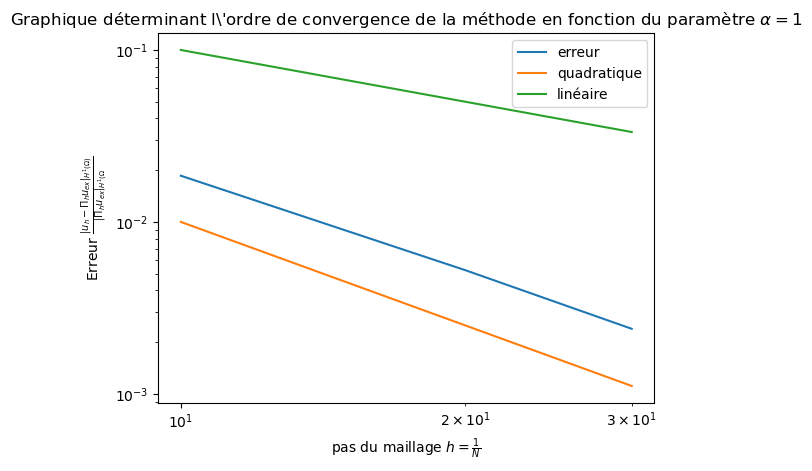

Temps d'exécution: 2.2099099159240723 secondes


In [51]:

start_time = time.time()


L1 = []
NL = []
NLQ = []
NLL = []
for N in [10,20,30]:
    Nx = N
    Ny = N
    Lx = 1
    Ly = 1
    alpha = 1
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    vtx,elt = GeometricRefinement(vtx,elt,0)
    bord = Boundary(elt)
    M =  Mass(vtx,elt)
    K = Rig(vtx,elt,Lx,Ly)
    Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
    Interp = interpolation_u_ex(vtx,alpha,Lx,Ly)
    erro = Uh - Interp
    val1 = H1(erro,Interp,M,K)
    L1.append(val1)
    NL.append(N)
    NLQ.append(1/N**2)
    NLL.append(1/N)
    
end_time = time.time()

execution_time = end_time - start_time

plt.loglog(NL,L1, label = "erreur")
plt.plot(NL,NLQ, label = "quadratique")
plt.plot(NL,NLL,label= "linéaire")
plt.title(r'Graphique déterminant l\'ordre de convergence de la méthode en fonction du paramètre $\alpha = 1$')
plt.xlabel(r'pas du maillage $h = \frac{1}{N}$') # N = Nx = Ny ici
plt.ylabel(r'Erreur $\frac{\|u_h - \Pi_h u_{ex}\|_{H^1(\Omega)}}{\|\Pi_h u_{ex}\|_{H^1(\Omega}}$')
plt.legend()
plt.savefig("err norme h1 alpha = 1")
plt.show()
print("Temps d'exécution:", execution_time, "secondes")

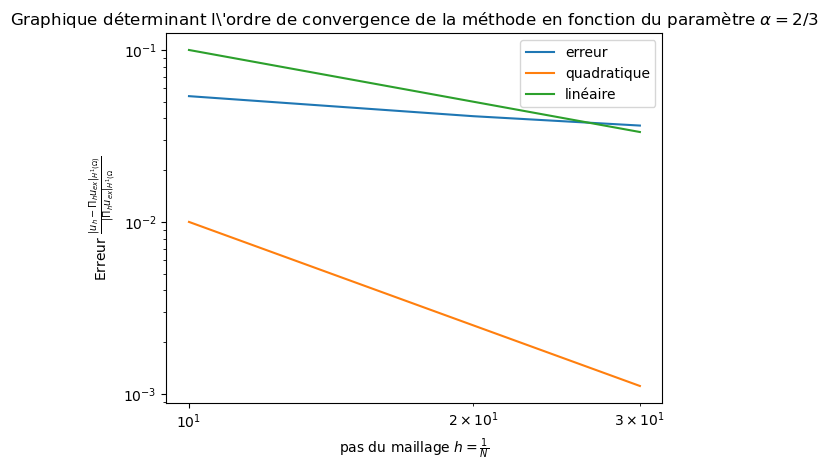

Temps d'exécution: 2.2978813648223877 secondes


In [52]:
start_time = time.time()

L1 = []
NL = []
NLQ = []
NLL = []
for N in [10,20,30]:
    Nx = N
    Ny = N
    Lx = 1
    Ly = 1
    alpha = 2/3
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    vtx,elt = GeometricRefinement(vtx,elt,0)
    bord = Boundary(elt)
    M =  Mass(vtx,elt)
    K = Rig(vtx,elt,Lx,Ly)
    Uh = systeme_lineaire(Lx,Ly,Nx,Ny,alpha,vtx,elt,bord)
    Interp = interpolation_u_ex(vtx,alpha,Lx,Ly)
    erro = Uh - Interp
    val1 = H1(erro,Interp,M,K)
    L1.append(val1)
    NL.append(N)
    NLQ.append(1/N**2)
    NLL.append(1/N)
end_time = time.time()

execution_time = end_time - start_time
plt.loglog(NL,L1, label = "erreur")
plt.plot(NL,NLQ, label = "quadratique")
plt.plot(NL,NLL,label= "linéaire")
plt.title(r'Graphique déterminant l\'ordre de convergence de la méthode en fonction du paramètre $\alpha = 2/3$')
plt.xlabel(r'pas du maillage $h = \frac{1}{N}$') # N = Nx = Ny ici
plt.ylabel(r'Erreur $\frac{\|u_h - \Pi_h u_{ex}\|_{H^1(\Omega)}}{\|\Pi_h u_{ex}\|_{H^1(\Omega}}$')
plt.legend()
plt.savefig("err norme h1 alpha = 2")
plt.show()
print("Temps d'exécution:", execution_time, "secondes")